##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer Learning for the Audio Domain with TensorFlow Lite Model Maker

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/models/modify/model_maker/audio_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/audio_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/audio_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/models/modify/model_maker/audio_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/yamnet/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>

</table>


In this colab notebook, you'll learn how to use the [TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/models/modify/model_maker) to train a custom audio classification model.

The Model Maker library uses transfer learning to simplify the process of training a TensorFlow Lite model using a custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data and time required.

It is part of the [Codelab to Customize an Audio model and deploy on Android](https://codelabs.developers.google.com/codelabs/tflite-audio-classification-custom-model-android).

You'll use a custom birds dataset and export a TFLite model that can be used on a phone, a TensorFlow.JS model that can be used for inference in the browser and also a SavedModel version that you can use for serving.


## Intalling dependencies


In [1]:
!sudo apt -y install libportaudio2
!pip install tflite-model-maker

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 1s (68.9 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

## Import TensorFlow, Model Maker and other libraries

Among the dependencies that are needed, you'll use TensorFlow and Model Maker. Aside those, the others are for audio manipulation, playing and visualizations.

In [ ]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random
from google.colab import files

from IPython.display import Audio, Image
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

TensorFlow Version: 2.8.2
Model Maker Version: 0.4.0


In [ ]:
from google.colab import drive
drive.flush_and_unmount
drive.mount('/content/drive', force_remount=True)
# Dados no Gdrive de Tiago
PATH_TIAGO = '/content/drive/My Drive/HEAR/__Programacao/repos/Datasets/HEAR_DATASETV3/dataset/socorro_dataset/' 
os.chdir(PATH_TIAGO)

Mounted at /content/drive


## Explore the data

The audios are already split in train and test folders. Inside each split folder, there's one folder for each bird, using their `bird_code` as name.

The audios are all mono and with 16kHz sample rate.

For more information about each file, you can read the `metadata.csv` file. It contains all the files authors, lincenses and some more information. You won't need to read it yourself on this tutorial.

In [ ]:
# @title [Run this] Util functions and data structures.

data_dir = PATH_TIAGO #

bird_code_to_name = {
  'socorro': 'socorro',
  'silencio': 'silencio',
  'outros': 'outros',  
  'homonima': 'homonima',
  'conversa': 'conversa',
  'barulho' : 'barulho'   
}

birds_images = {
  'socorro':  'https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Henicorhina_leucosticta_%28Cucarachero_pechiblanco%29_-_Juvenil_%2814037225664%29.jpg/640px-Henicorhina_leucosticta_%28Cucarachero_pechiblanco%29_-_Juvenil_%2814037225664%29.jpg', # 	Alejandro Bayer Tamayo from Armenia, Colombia 
  'silencio': 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/52/House_Sparrow%2C_England_-_May_09.jpg/571px-House_Sparrow%2C_England_-_May_09.jpg', # 	Diliff
  'outros':   'https://upload.wikimedia.org/wikipedia/commons/thumb/4/49/Red_Crossbills_%28Male%29.jpg/640px-Red_Crossbills_%28Male%29.jpg', #  Elaine R. Wilson, www.naturespicsonline.com
  'homonima': 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/Chestnut-crowned_antpitta_%2846933264335%29.jpg/640px-Chestnut-crowned_antpitta_%2846933264335%29.jpg', # 	Mike's Birds from Riverside, CA, US
  'conversa': 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Synallaxis_azarae_76608368.jpg/640px-Synallaxis_azarae_76608368.jpg', # https://www.inaturalist.org/photos/76608368
  'barulho' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Synallaxis_azarae_76608368.jpg/640px-Synallaxis_azarae_76608368.jpg',
}

test_files = os.path.abspath(os.path.join(data_dir, 'test/*/*.wav'))

def get_random_audio_file():
  test_list = glob.glob(test_files)
  random_audio_path = random.choice(test_list)
  return random_audio_path


def show_data(audio_path):
  sample_rate, audio_data = wavfile.read(audio_path, 'rb')

  bird_code = audio_path.split('/')[-2]
  print(f'name: {bird_code_to_name[bird_code]}')
  print(f'code: {bird_code}')
  #display(Image(birds_images[bird_code]))

  plttitle = f'{bird_code_to_name[bird_code]} ({bird_code})'
  plt.title(plttitle)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

print('functions and data structures created')

functions and data structures created


### Playing some audio

To have a better understanding about the data, lets listen to a random audio files from the test split.

Note: later in this notebook you'll run inference on this audio for testing

name: silencio
code: silencio


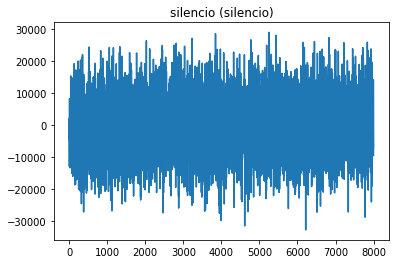

In [ ]:
random_audio = get_random_audio_file()
show_data(random_audio)

## Training the Model

When using Model Maker for audio, you have to start with a model spec. This is the base model that your new model will extract information to learn about the new classes. It also affects how the dataset will be transformed to respect the models spec parameters like: sample rate, number of channels.

[YAMNet](https://tfhub.dev/google/yamnet/1) is an audio event classifier trained on the AudioSet dataset to predict audio events from the AudioSet ontology.

It's input is expected to be at 16kHz and with 1 channel.

You don't need to do any resampling yourself. Model Maker takes care of that for you.

- `frame_length` is to decide how long each traininng sample is. in this caase EXPECTED_WAVEFORM_LENGTH * 3s

- `frame_steps` is to decide how far appart are the training samples. In this case, the ith sample will start at EXPECTED_WAVEFORM_LENGTH * 6s after the (i-1)th sample.

The reason to set these values is to work around some limitation in real world dataset.

For example, in the bird dataset, birds don't sing all the time. They sing, rest and sing again, with noises in between. Having a long frame would help capture the singing, but setting it too long will reduce the number of samples for training.


In [ ]:
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=True,
    frame_step=1 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
    frame_length=1 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

INFO:tensorflow:Checkpoints are stored in /tmp/tmp92xoebtd


INFO:tensorflow:Checkpoints are stored in /tmp/tmp92xoebtd


## Loading the data

Model Maker has the API to load the data from a folder and have it in the expected format for the model spec.

The train and test split are based on the folders. The validation dataset will be created as 20% of the train split.

Note: The `cache=True` is important to make training later faster but it will also require more RAM to hold the data. For the birds dataset that is not a problem since it's only 300MB, but if you use your own data you have to pay attention to it.


In [ ]:
train_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'train'), cache=True)
train_data, validation_data = train_data.split(0.8)
test_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'test'), cache=True)

## Training the model

the audio_classifier has the [`create`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/create) method that creates a model and already start training it. 

You can customize many parameterss, for more information you can read more details in the documentation.

On this first try you'll use all the default configurations and train for 100 epochs.

Note: The first epoch takes longer than all the other ones because it's when the cache is created. After that each epoch takes close to 1 second.

In [ ]:
batch_size = 128
epochs = 100

print('Training the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    batch_size=batch_size,
    epochs=epochs)

Training the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_head (Dense)  (None, 5)                5125      
                                                                 
Total params: 5,125
Trainable params: 5,125
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
    101/Unknown - 12369s 119s/step - loss: 0.7273 - acc: 0.7661

The accuracy looks good but it's important to run the evaluation step on the test data and vefify your model achieved good results on unseed data.

In [ ]:
print('Evaluating the model')
model.evaluate(test_data)

## Understanding your model

When training a classifier, it's useful to see the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The confusion matrix gives you detailed knowledge of how your classifier is performing on test data.

Model Maker already creates the confusion matrix for you.

In [ ]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

## Testing the model [Optional]

You can try the model on a sample audio from the test dataset just to see the results.

First you get the serving model.

In [ ]:
serving_model = model.create_serving_model()

print(f'Model\'s input shape and type: {serving_model.inputs}')
print(f'Model\'s output shape and type: {serving_model.outputs}')

Coming back to the random audio you loaded earlier

In [ ]:
# if you want to try another file just uncoment the line below
random_audio = get_random_audio_file()
show_data(random_audio)

The model created has a fixed input window. 

For a given audio file, you'll have to split it in windows of data of the expected size. The last window might need to be filled with zeros.

In [ ]:
sample_rate, audio_data = wavfile.read(random_audio, 'rb')

audio_data = np.array(audio_data) / tf.int16.max
input_size = serving_model.input_shape[1]

splitted_audio_data = tf.signal.frame(audio_data, input_size, input_size, pad_end=True, pad_value=0)

print(f'Test audio path: {random_audio}')
print(f'Original size of the audio data: {len(audio_data)}')
print(f'Number of windows for inference: {len(splitted_audio_data)}')

You'll loop over all the splitted audio and apply the model for each one of them.

The model you've just trained has 2 outputs: The original YAMNet's output and the one you've just trained. This is important because the real world environment is more complicated than just bird sounds. You can use the YAMNet's output to filter out non relevant audio, for example, on the birds use case, if YAMNet is not classifying Birds or Animals, this might show that the output from your model might have an irrelevant classification.


Below both outpus are printed to make it easier to understand their relation. Most of the mistakes that your model make are when YAMNet's prediction is not related to your domain (eg: birds).

In [ ]:
print(random_audio)

results = []
print('Result of the window ith:  your model class -> score,  (spec class -> score)')
for i, data in enumerate(splitted_audio_data):
  yamnet_output, inference = serving_model(data)
  results.append(inference[0].numpy())
  result_index = tf.argmax(inference[0])
  spec_result_index = tf.argmax(yamnet_output[0])
  t = spec._yamnet_labels()[spec_result_index]
  result_str = f'Result of the window {i}: ' \
  f'\t{test_data.index_to_label[result_index]} -> {inference[0][result_index].numpy():.3f}, ' \
  f'\t({spec._yamnet_labels()[spec_result_index]} -> {yamnet_output[0][spec_result_index]:.3f})'
  print(result_str)


results_np = np.array(results)
mean_results = results_np.mean(axis=0)
result_index = mean_results.argmax()
print(f'Mean result: {test_data.index_to_label[result_index]} -> {mean_results[result_index]}')

## Exporting the model

The last step is exporting your model to be used on embedded devices or on the browser.

The `export` method export both formats for you.

In [ ]:
models_path = './hear_models'
print(f'Exporing the TFLite model to {models_path}')

model.export(models_path, tflite_filename='hear_model.tflite')

You can also export the SavedModel version for serving or using on a Python environment.

In [ ]:
model.export(models_path, export_format=[mm.ExportFormat.SAVED_MODEL, mm.ExportFormat.LABEL])

## Next Steps

You did it.

Now your new model can be deployed on  mobile devices using [TFLite AudioClassifier Task API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/audio_classifier).

You can also try the same process with your own data with different classes and here is the documentation for [Model Maker for Audio Classification](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier).

Also learn from end-to-end reference apps: [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/sound_classification/android/), [iOS](https://github.com/tensorflow/examples/tree/master/lite/examples/sound_classification/ios).